In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os,cv2, numpy as np
import torch
from torch.nn import *
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter('/content/runs/')


In [3]:
!unzip -q /content/gdrive/My\ Drive/segmentation_archive.zip -d /content/Data/
!unzip -q /content/gdrive/My\ Drive/segmentation_archive_masks.zip -d /content/Data/

replace /content/Data/images/images/Abyssinian_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!rm -rf /content/Data/images/images
!mv /content/Data/annotations/annotations/trimaps/* /content/Data/annotations/
!rm -rf /content/Data/annotations/annotations
!rm -rf /content/Data/images/*.mat

In [5]:

from PIL import Image
from torchvision.transforms import transforms

def transform_(mean_, std_):
    transform = transforms.Compose([
                  transforms.Resize((128,128)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean_, std_),
                  ])
    return transform

meanbg = [0.449,0.367, 0.308]
stdbg = [0.226,0.217,0.208]
transformi = transform_(meanbg, stdbg)
for p,d,f in os.walk('/content/Data/images/'):
  for f1 in f:
   im = Image.open(p+f1)
   try:
    im = transformi(im)
   except:
    os.remove(p+f1)
    os.remove('/content/Data/annotations/'+f1.split('.')[0]+'.png')

In [6]:
print(sum(len(f1) for p,d,f1 in os.walk('/content/Data/images/')))
print(sum(len(f1) for p,d,f1 in os.walk('/content/Data/annotations/')))

7378
7378


#Creating model

In [7]:
import torch
import torch.nn as nn

# Define Encoder MiniBlock
class EncoderMiniBlock(nn.Module):
    def __init__(self, n_filters_in, n_filters, dropout_prob=0.3, max_pooling=True):
        super(EncoderMiniBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_filters_in, n_filters, 3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, n_filters, 3, padding=1)
        self.batchnorm = nn.BatchNorm2d(n_filters)
        self.dropout = nn.Dropout2d(dropout_prob)
        self.max_pooling = max_pooling
        self.strided_conv = nn.Conv2d(n_filters, n_filters, 3, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.batchnorm(x)
        if self.dropout.p > 0:
            x = self.dropout(x)
        if self.max_pooling:
            skip_connection = x.clone()
            x =  self.strided_conv(x) #nn.MaxPool2d(2)(x) #Replaced maxpool by strided convolution
        else:
            skip_connection = x.clone()
        return x, skip_connection

# Define Decoder MiniBlock
class DecoderMiniBlock(nn.Module):
    def __init__(self, n_filters):
        super(DecoderMiniBlock, self).__init__()
        #self.conv1 = nn.ConvTranspose2d(n_filters, n_filters, 3, stride=2, padding=1, output_padding=1)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv1 = nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n_filters * 2, n_filters, 3, padding=1)
        self.batchnorm = nn.BatchNorm2d(n_filters)
        #self.conv3 = nn.Conv2d(n_filters, n_filters/2, 1)

    def forward(self, x, skip_connection):
        x = self.conv1(self.upsample(x))
        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.batchnorm(x)
        #x = self.conv3(x)
        return x

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, n_classes, n_filters=32):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_filters = n_filters


        # Encoder blocks
        self.cblock1 = EncoderMiniBlock(3, n_filters, dropout_prob=0, max_pooling=True)
        self.cblock2 = EncoderMiniBlock(n_filters, n_filters * 2, dropout_prob=0, max_pooling=True)
        self.cblock3 = EncoderMiniBlock(n_filters*2, n_filters * 4, dropout_prob=0, max_pooling=True)
        self.cblock4 = EncoderMiniBlock(n_filters*4, n_filters * 8, dropout_prob=0.3, max_pooling=True)
        self.cblock5 = EncoderMiniBlock(n_filters*8, n_filters * 16, dropout_prob=0.3, max_pooling=False)

        # Final convolution layers
        self.conv1 = nn.Conv2d(n_filters * 16, n_filters*8, 1)
        self.conv2 = nn.Conv2d(n_filters * 8, n_filters*4, 1)
        self.conv3 = nn.Conv2d(n_filters * 4, n_filters*2, 1)
        self.conv4 = nn.Conv2d(n_filters * 2, n_filters*1, 1)


        # Decoder blocks
        self.ublock6 = DecoderMiniBlock(n_filters * 8)
        self.ublock7 = DecoderMiniBlock(n_filters * 4)
        self.ublock8 = DecoderMiniBlock(n_filters * 2)
        self.ublock9 = DecoderMiniBlock(n_filters)

        # Final convolution layers
        self.conv9 = nn.Conv2d(n_filters, n_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        cblock1, skip1 = self.cblock1(x)
        cblock2, skip2 = self.cblock2(cblock1)
        cblock3, skip3 = self.cblock3(cblock2)
        cblock4, skip4 = self.cblock4(cblock3)
        cblock5, _ = self.cblock5(cblock4)

        cblock5 = self.conv1(cblock5)
        # Decoder
        ublock6 = self.ublock6(cblock5, skip4)
        ublock6 = self.conv2(ublock6)
        ublock7 = self.ublock7(ublock6, skip3)
        ublock7 = self.conv3(ublock7)
        ublock8 = self.ublock8(ublock7, skip2)
        ublock8 = self.conv4(ublock8)
        ublock9 = self.ublock9(ublock8, skip1)

        # Final convolution layer
        output = self.conv9(ublock9)

        return output

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(3).to(device)
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]           9,248
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 112, 112]           9,248
  EncoderMiniBlock-5  [[-1, 32, 112, 112], [-1, 32, 224, 224]]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
            Conv2d-7         [-1, 64, 112, 112]          36,928
       BatchNorm2d-8         [-1, 64, 112, 112]             128
            Conv2d-9           [-1, 64, 56, 56]          36,928
 EncoderMiniBlock-10  [[-1, 64, 56, 56], [-1, 64, 112, 112]]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
           Conv2d-12          [-1, 128, 56, 56]         147,584
      BatchNorm2d-13          [-1, 128, 56, 56]             256
           

#Forming Dataset/Dataloader

In [9]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from pathlib import Path
from PIL import Image
import cv2
from pathlib import Path

def transform_(mean_, std_):
    transform = transforms.Compose([
                  transforms.Resize((128,128)),
                  transforms.ToTensor(),
                  #transforms.Normalize(mean_, std_),
                  ])
    return transform

def transform__():
    transform = transforms.Compose([
                  transforms.Resize((128,128)),
                  transforms.ToTensor(),
                  #transforms.Normalize(mean_, std_),
                  ])
    return transform

def getmaps():
    images = {}
    masks = {}
    root_dir = '/content/Data/'
    f1 = Path(root_dir+'images/')
    f2 = Path(root_dir+'annotations/')
    f1_files = list(sorted(f1.glob('*.jpg')))
    f2_files = list(sorted(f2.glob('*.png')))

    for idx, (i, j) in enumerate(zip(f1_files, f2_files)):
      images[idx] = str(i)
      masks[idx] = str(j)

    return images,masks

class LoadDataset(Dataset):
  def __init__(self):
    self.meanbg = [0.449,0.367, 0.308]
    self.stdbg = [0.226,0.217,0.208]
    self.leng = sum(len(f1) for p,d,f1 in os.walk('/content/Data/images/'))
    self.images, self.masks = getmaps()
    self.transformi = transform_(self.meanbg, self.stdbg)
    self.transformm = transform__()

  def __len__(self):
    return self.leng

  def __getitem__(self, idx):
    images = Image.open(self.images[idx])
    w,h = images.size
    masks1 = cv2.imread(self.masks[idx])[:,:,0]
    masks = np.zeros((h,w,3), dtype='uint8')
    masks[:,:,0]=255*(masks1==1)
    masks[:,:,1]=255*(masks1==2)
    masks[:,:,2]=255*(masks1==3)
    masks = Image.fromarray(masks)
    timage = self.transformi(images)
    tmask = self.transformm(masks)

    return {'image': timage,'mask': tmask}

In [10]:
train_ds = LoadDataset()
train_set, val_set = torch.utils.data.random_split(train_ds, [int(6000), int(1378)])
train_dl = DataLoader(train_set, batch_size = 16, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_set, batch_size = 16, shuffle=True, pin_memory=True )

#Data visualization

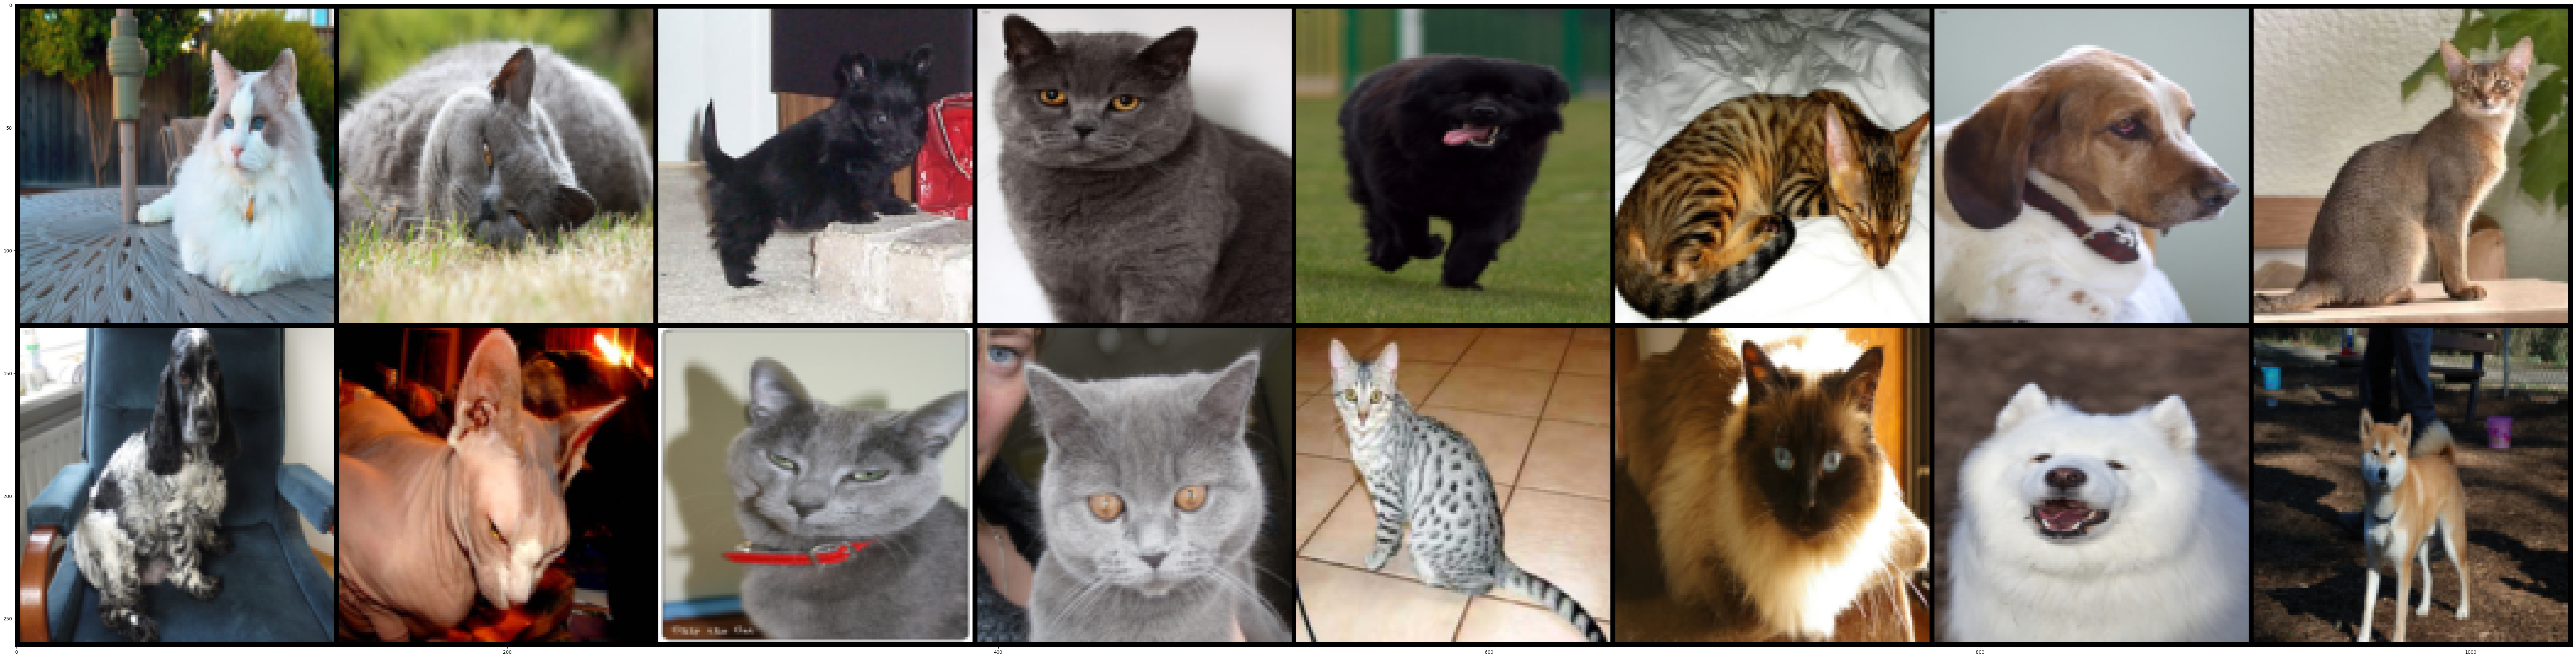

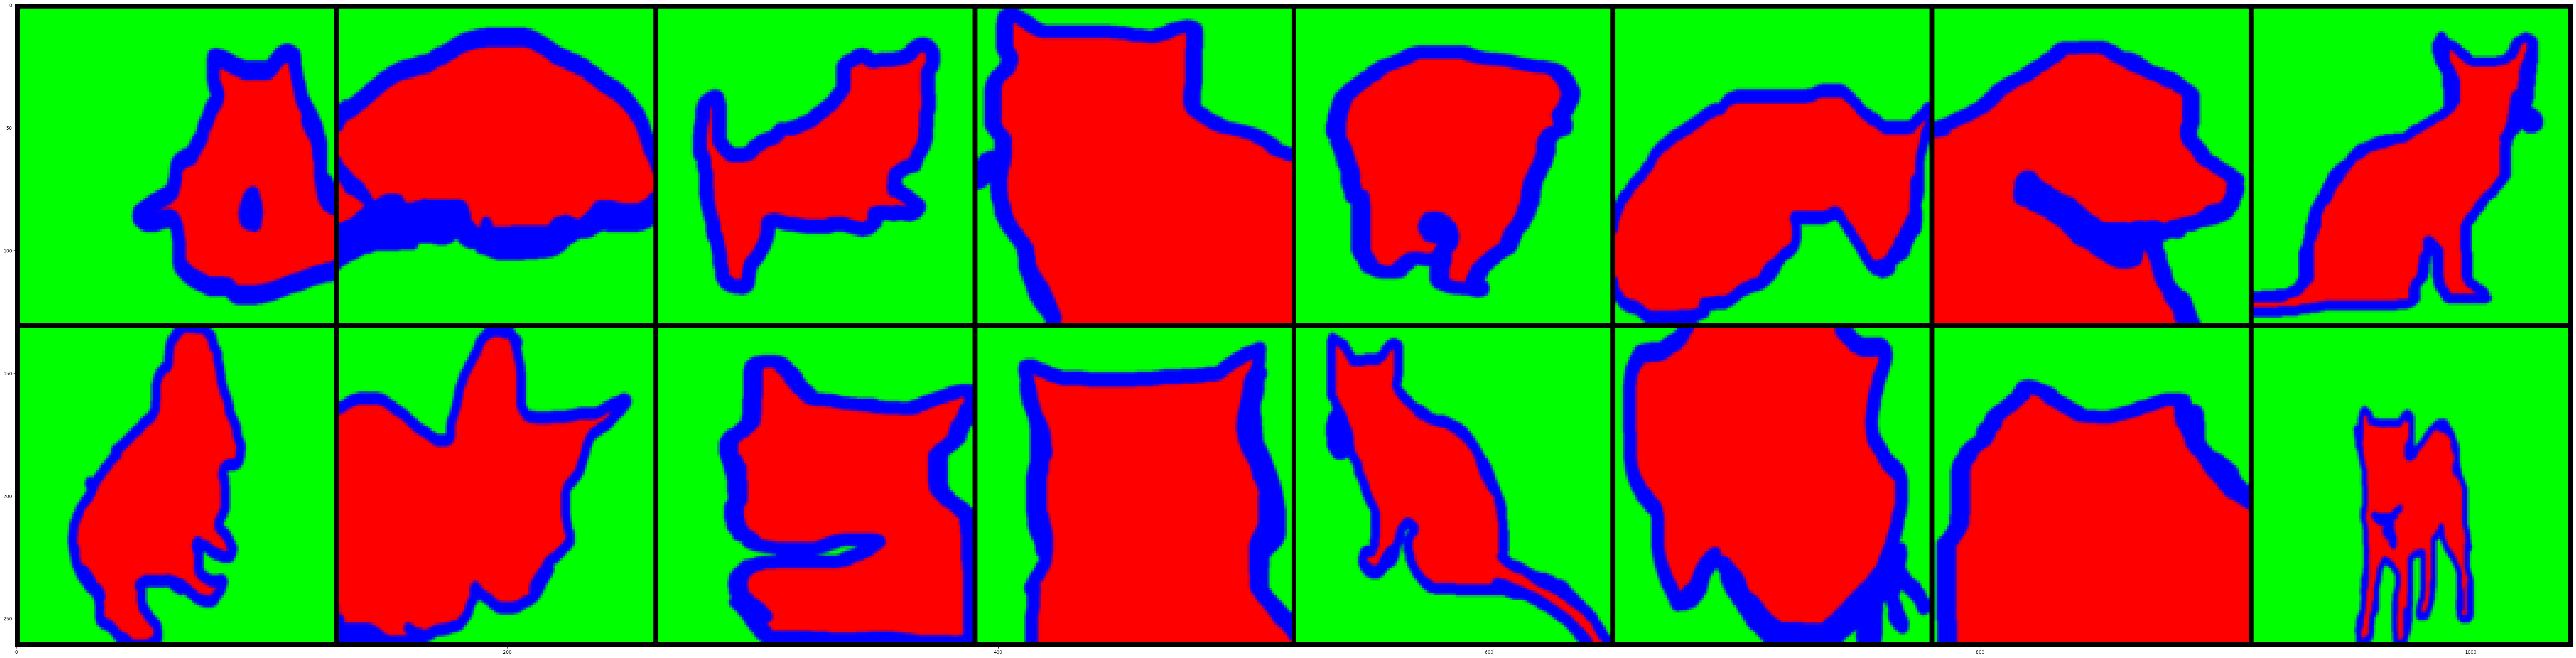

In [11]:
import torchvision
import matplotlib.pyplot as plt

def show1(tensors1, mul):
  grid_tensor1 = mul*torchvision.utils.make_grid(tensors1.detach().cpu())
  grid_image1 = grid_tensor1.permute(1,2,0)
  plt.figure(figsize=(100,100))
  plt.imshow(grid_image1)
  plt.show()

sample1 = iter(train_dl)
sample = next(sample1)
imgs = sample["image"]
show1(imgs, 1)
masks = sample["mask"]
show1(masks, 1)

#Hyperparameter tuning

In [12]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler

class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

criterion = diceloss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=1e-5)
scheduler=lr_scheduler.OneCycleLR(optimizer, max_lr=5.38E-02, steps_per_epoch=2, epochs=20, pct_start=0.25, div_factor=100, final_div_factor=100, three_phase=True, anneal_strategy='linear')

#Training/Valudation

In [13]:
import tensorflow as tf
from tqdm.notebook import tqdm
import time
from tensorflow import summary


def train(model, criterion, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0.0  # Track the total loss for the epoch
    pbar = tqdm(iter(train_loader), dynamic_ncols=True)

    for batch_idx, data in enumerate(pbar):
        if batch_idx == 0:
            t0 = time.time()

        # Move data to the device
        data["image"] = data["image"].to(device)
        data["mask"] = data["mask"].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data["image"])

        # Ensure the output is in the range [0, 1] using a sigmoid activation
        output = torch.sigmoid(output)

        # Compute the loss
        batch_loss = criterion(output, data["mask"])

        # Backpropagation and optimization step
        batch_loss.backward()
        optimizer.step()

        # Accumulate the batch loss
        total_loss += batch_loss.item()

    # Calculate and print the average loss for the epoch
    avg_loss = total_loss / len(train_dl)

    print(f"Epoch {epoch}/{30}, Average Loss: {avg_loss:.4f}")
    return avg_loss

def test(model, criterion, device, test_loader, epoch):
    model.eval()
    total_loss = 0.0  # Track the total loss for the epoch
    pbar = tqdm(iter(test_loader), dynamic_ncols=True)

    for batch_idx, data in enumerate(pbar):
        if batch_idx == 0:
            t0 = time.time()

        # Move data to the device
        data["image"] = data["image"].to(device)
        data["mask"] = data["mask"].to(device)

        # Forward pass
        output = model(data["image"])

        # Ensure the output is in the range [0, 1] using a sigmoid activation
        output = torch.sigmoid(output)

        # Compute the loss
        batch_loss = criterion(output, data["mask"])

        # Backpropagation and optimization step
        #batch_loss.backward()
        #optimizer.step()

        # Accumulate the batch loss
        total_loss += batch_loss.item()

    # Calculate and print the average loss for the epoch
    avg_loss = total_loss / len(train_dl)
    print(f"Epoch {epoch}/{30}, Average test Loss: {avg_loss:.4f}")
    return avg_loss


In [14]:
#device = torch.device("cpu")
#model = Model.Net().to(device)
for epoch in range(1, 20):
    for param_group in optimizer.param_groups:
        print("lr= ",param_group['lr'])
    train_loss = train(model, criterion, device, train_dl, optimizer, epoch)
    test_loss = test(model, criterion, device, val_dl, epoch)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/test", test_loss, epoch)

    scheduler.step()
writer.flush()

lr=  0.000538


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/30, Average Loss: 0.3232


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1/30, Average test Loss: 0.0533
lr=  0.006456000000000001


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/30, Average Loss: 0.1817


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2/30, Average test Loss: 0.0405
lr=  0.012374000000000001


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/30, Average Loss: 0.1393


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3/30, Average test Loss: 0.0304
lr=  0.018292


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/30, Average Loss: 0.1203


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4/30, Average test Loss: 0.0244
lr=  0.024210000000000002


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/30, Average Loss: 0.1091


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 5/30, Average test Loss: 0.0275
lr=  0.030128000000000002


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6/30, Average Loss: 0.1003


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 6/30, Average test Loss: 0.0219
lr=  0.036045999999999995


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7/30, Average Loss: 0.0938


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 7/30, Average test Loss: 0.0225
lr=  0.041964


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8/30, Average Loss: 0.0865


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 8/30, Average test Loss: 0.0214
lr=  0.047882


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9/30, Average Loss: 0.0821


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 9/30, Average test Loss: 0.0200
lr=  0.0538


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10/30, Average Loss: 0.0795


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 10/30, Average test Loss: 0.0184
lr=  0.047882


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11/30, Average Loss: 0.0725


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 11/30, Average test Loss: 0.0174
lr=  0.041964


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12/30, Average Loss: 0.0685


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 12/30, Average test Loss: 0.0180
lr=  0.036046


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 13/30, Average Loss: 0.0647


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 13/30, Average test Loss: 0.0171
lr=  0.030128


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 14/30, Average Loss: 0.0592


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 14/30, Average test Loss: 0.0178
lr=  0.02421


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 15/30, Average Loss: 0.0553


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 15/30, Average test Loss: 0.0165
lr=  0.018292000000000003


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 16/30, Average Loss: 0.0518


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 16/30, Average test Loss: 0.0156
lr=  0.012373999999999996


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 17/30, Average Loss: 0.0484


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 17/30, Average test Loss: 0.0155
lr=  0.0064559999999999965


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 18/30, Average Loss: 0.0460


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 18/30, Average test Loss: 0.0154
lr=  0.0005379999999999968


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 19/30, Average Loss: 0.0440


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch 19/30, Average test Loss: 0.0151


#Predictions

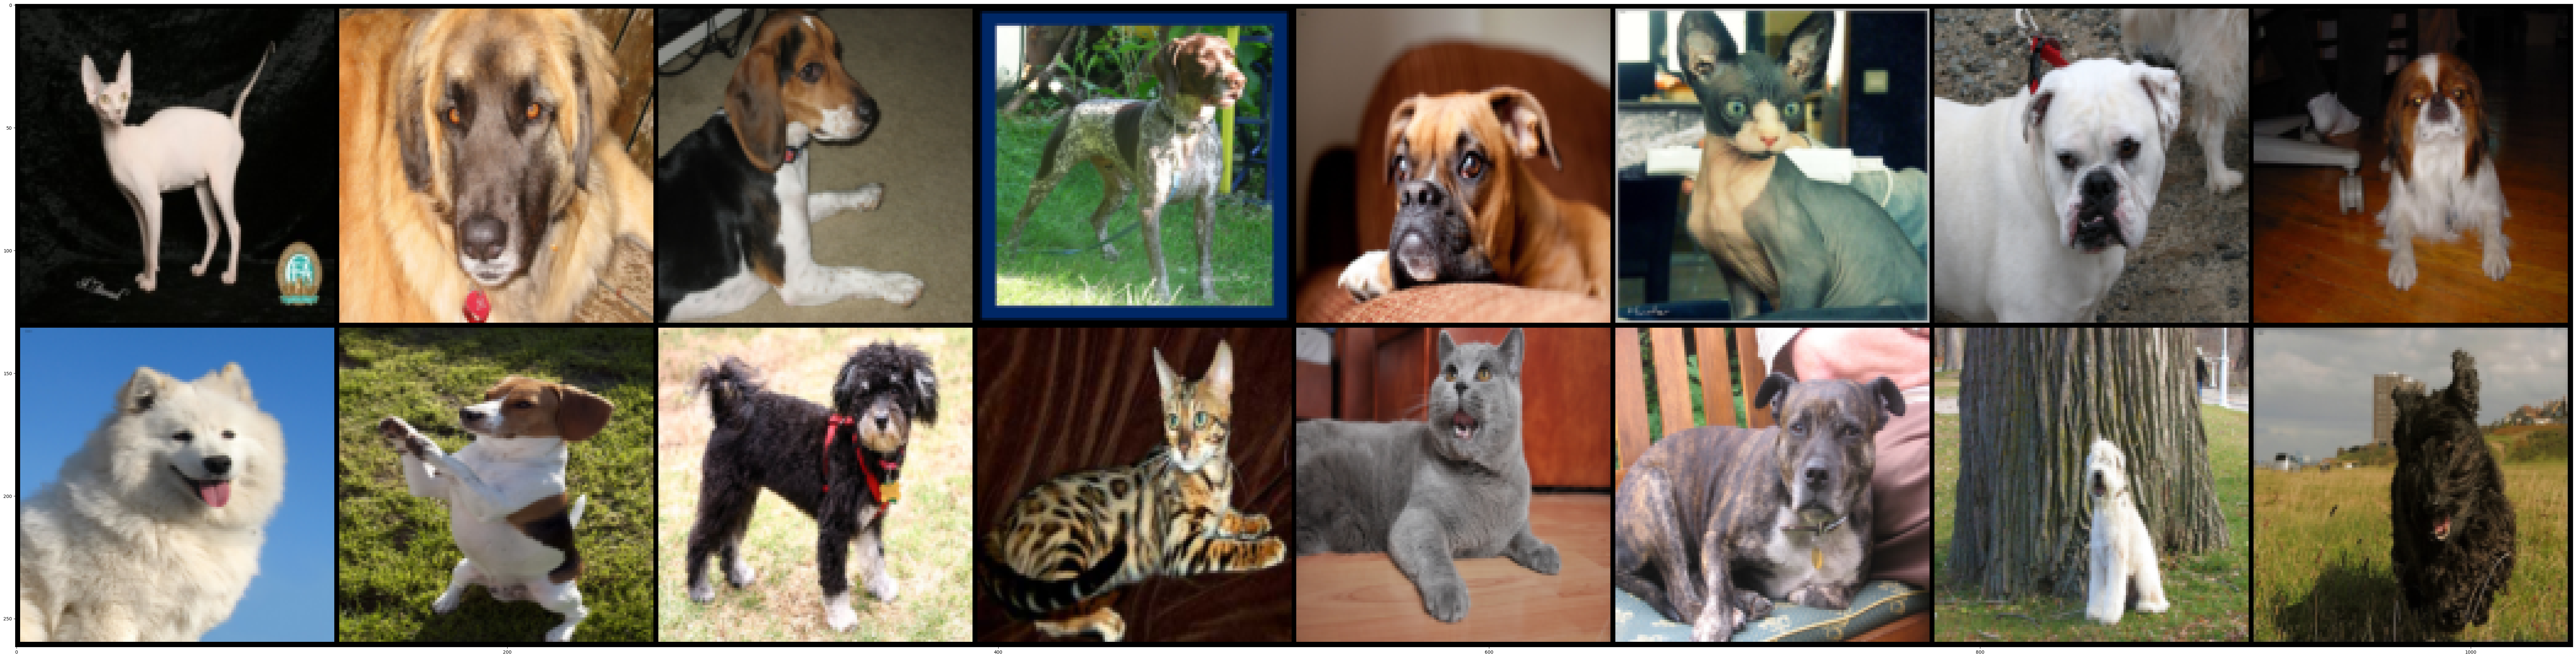

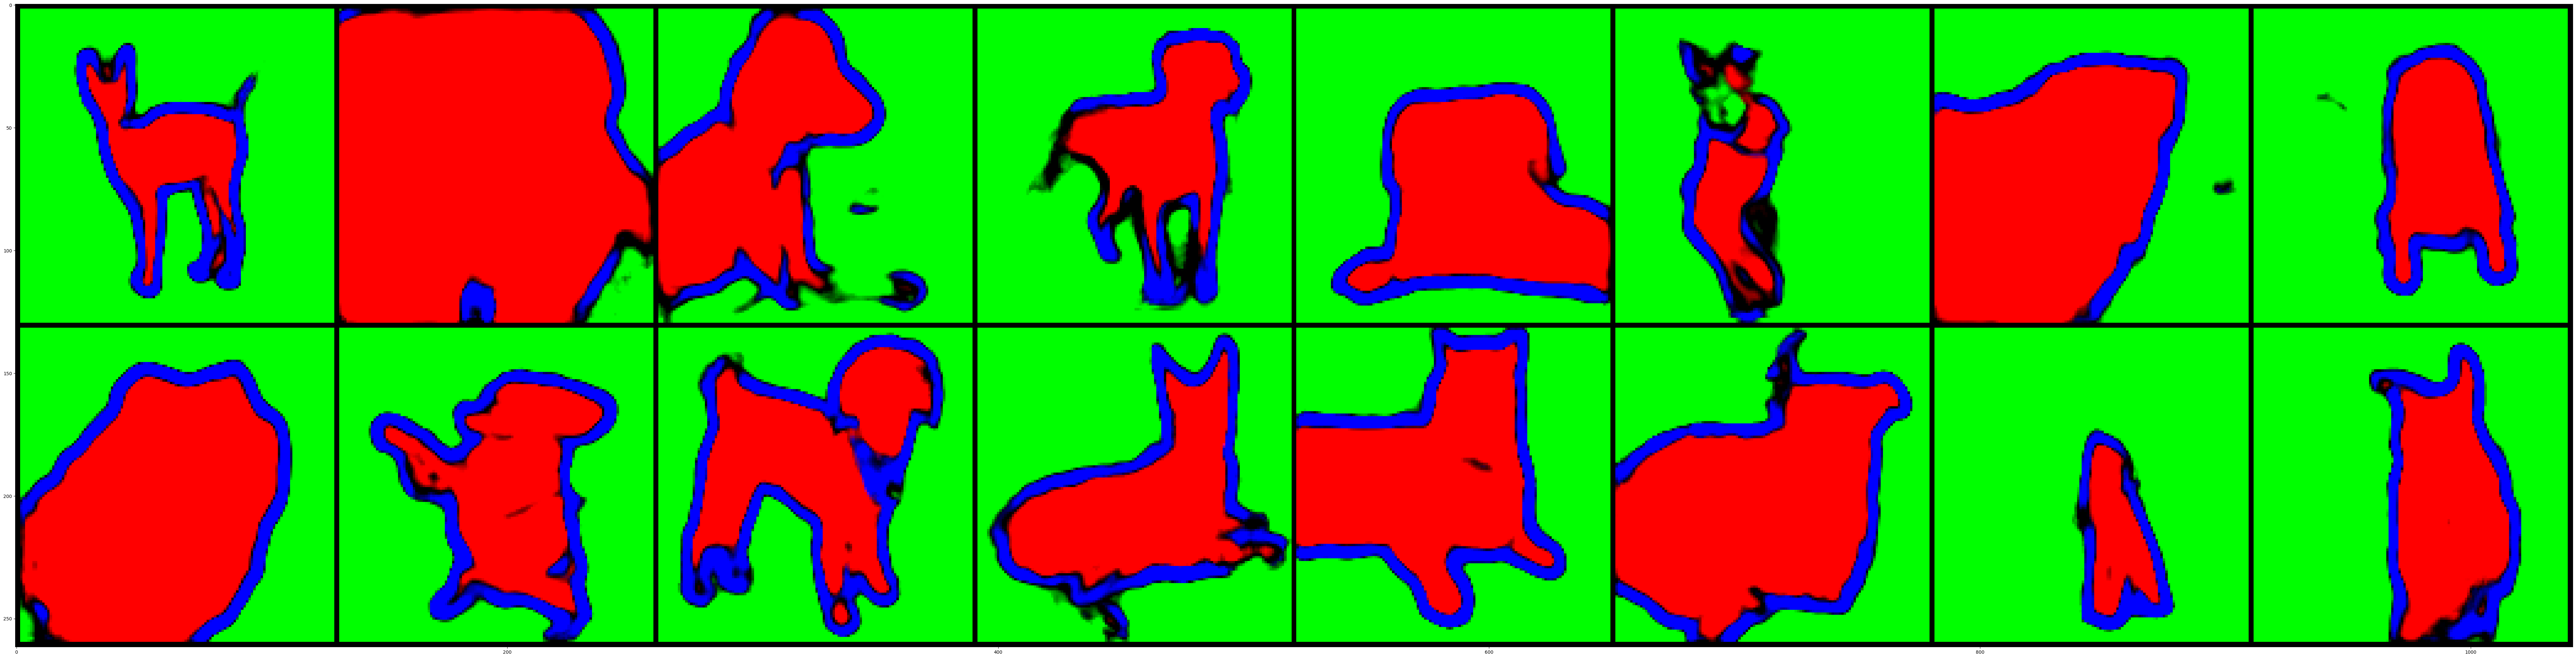

In [15]:
sample1 = iter(val_dl)
sample = next(sample1)
imgs = sample["image"].to(device)
out = model(imgs)
show1(imgs, 1)
show1(out, 1)

In [ ]:
%load_ext tensorboard

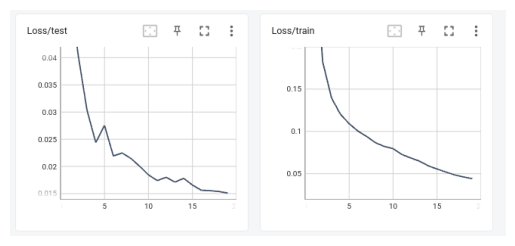

In [16]:
import cv2
import matplotlib.pyplot as plt

# Load the image (replace 'your_image.jpg' with the actual file name)
image_path = '/content/tensorboard4.png'
image = cv2.imread(image_path)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axis
plt.show()